In [1]:
from IPython.display import FileLink

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate

import os
import imageio.v2 as imageio  

In [3]:
#initial parameters
n = 1000
RV = np.arange(-18000,18001,500)

In [4]:
data_matrices = {}
for i in range(n):
    filename = f'STARSIM_output_CCFr_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i}'] = data_matrix

In [5]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'][:,1:]

In [6]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'].T
for i in range(n):
    data_matrices[f'd{i}'] = np.reshape(data_matrices[f'd{i}'],27*73)

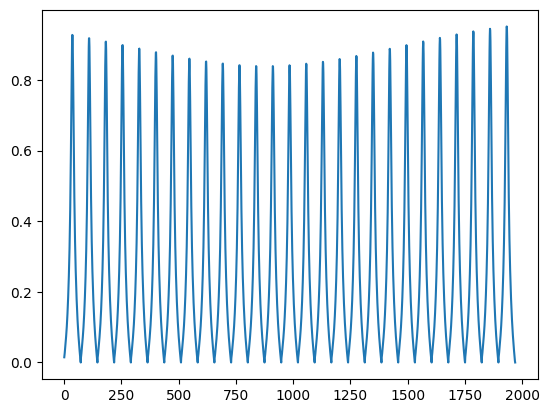

In [32]:
plt.plot(np.arange(0,73*27,1), data_matrices['d10'])

In [7]:
n_train = int(n*0.9*0.9)
n_val = int(n*0.9*0.1)
n_test = n-n_train-n_val

train_data = []
val_data = []
test_data = []

In [8]:
for i in range(n_train):
    train_data.append(data_matrices[f'd{i}'])

for i in range(n_train,n_train+n_val,1):
    val_data.append(data_matrices[f'd{i}'])
    
for i in range(n_train+n_val,n,1):
    test_data.append(data_matrices[f'd{i}'])

In [9]:
np.shape(test_data)

(100, 1971)

In [10]:
train_data = np.array(train_data).reshape(n_train,27*73)
val_data = np.array(val_data).reshape(n_val,27*73)
test_data = np.array(test_data).reshape(n_test, 27*73)

A partir d'aquí per a una CCF

In [11]:
train_data1 = []
test_data1 = []
val_data1 = []

In [12]:
for i in range(n_train):
    train_data1.append(train_data[i,0:73]) #agafem la primera CCF, de 73 punts
    
for i in range(n_test):
    test_data1.append(test_data[i,0:73])
    
for i in range(n_val):
    val_data1.append(val_data[i,0:73])

In [13]:
train_data1 = np.array(train_data1).reshape(n_train,73,1)
test_data1 = np.array(test_data1).reshape(n_test,73,1)
val_data1 = np.array(val_data1).reshape(n_val,73,1)

In [14]:
np.shape(train_data1[0])

(73, 1)

In [69]:
latent_dims = np.arange(1,21,1)
lossesvecval = []
#for i in range(len(latent_dims)):


input_shape = (73,1)
latent_dim=60
class Autoencoder(Model):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_shape)),
            layers.Conv1D(16, kernel_size=9, activation='relu', padding='same'),
            layers.Conv1D(8, kernel_size=9, activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dense(70, activation='relu'),
            layers.Dense(latent_dim, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(70, activation='relu'),
            layers.Dense(100, activation='relu'),
            layers.Dense(73, activation='linear'),  # Adjusted to match input shape
            layers.Reshape((1,73,1)), 
            layers.Conv1D(8, kernel_size=9, activation='relu', padding='same'),
            layers.Conv1D(16, kernel_size=9, activation='relu', padding='same'),
            layers.Conv1D(1, kernel_size=9, activation='linear', padding='same')  
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_shape, latent_dim=latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

initial_learning_rate = 0.1
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

optimizer = tf.keras.optimizers.Adam()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data1, train_data1,
                          epochs=100,
                          shuffle=True,
                          batch_size=32,
                          validation_data=(val_data1, val_data1),
                           callbacks=[reduce_lr, early_stopping])


Epoch 1/100
26/26 [==============================] - 9s 168ms/step - loss: 9657.9170 - val_loss: 0.5322 - lr: 0.1000
Epoch 2/100
26/26 [==============================] - 3s 119ms/step - loss: 0.5560 - val_loss: 0.5564 - lr: 0.1000
Epoch 3/100
26/26 [==============================] - 3s 119ms/step - loss: 0.5405 - val_loss: 0.5183 - lr: 0.1000
Epoch 4/100
26/26 [==============================] - 3s 125ms/step - loss: 0.4973 - val_loss: 0.4719 - lr: 0.1000
Epoch 5/100
26/26 [==============================] - 3s 133ms/step - loss: 0.4500 - val_loss: 0.4242 - lr: 0.1000
Epoch 6/100
26/26 [==============================] - 3s 130ms/step - loss: 0.4027 - val_loss: 0.3777 - lr: 0.1000
Epoch 7/100
26/26 [==============================] - 3s 125ms/step - loss: 0.3572 - val_loss: 0.3336 - lr: 0.1000
Epoch 8/100
26/26 [==============================] - 3s 129ms/step - loss: 0.3146 - val_loss: 0.2929 - lr: 0.1000
Epoch 9/100
26/26 [==============================] - 3s 131ms/step - loss: 0.2757 - v

In [67]:
test_pred = test_data1[2].reshape(1,73)
predictions = autoencoder.predict(test_pred)
predictions = predictions.reshape(73,)

1/1 [==============================] - 0s 56ms/step


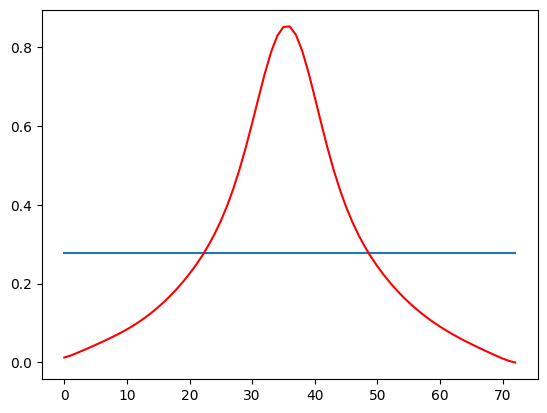

In [68]:
plt.plot(np.arange(0,73,1), predictions)
test2 = test_data1[2].reshape(73,)
plt.plot(np.arange(0,73,1), test2, color='red')